In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

tf.enable_eager_execution()

print(tf.VERSION)   # 1.11.0-dev20180917



1.11.0-dev20180917


In [2]:
# Retrieve the images
import pathlib
data_root = tf.keras.utils.get_file('flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', untar=True)
data_root = pathlib.Path(data_root)
print(data_root)

for item in data_root.iterdir():
    print(item) 


/home/yq0033/.keras/datasets/flower_photos
/home/yq0033/.keras/datasets/flower_photos/sunflowers
/home/yq0033/.keras/datasets/flower_photos/daisy
/home/yq0033/.keras/datasets/flower_photos/tulips
/home/yq0033/.keras/datasets/flower_photos/dandelion
/home/yq0033/.keras/datasets/flower_photos/LICENSE.txt
/home/yq0033/.keras/datasets/flower_photos/roses


In [3]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count


3670

In [4]:
all_image_paths[:10]


['/home/yq0033/.keras/datasets/flower_photos/roses/15750320284_22ef21c682.jpg',
 '/home/yq0033/.keras/datasets/flower_photos/roses/15061894841_e5aca59ecd_n.jpg',
 '/home/yq0033/.keras/datasets/flower_photos/roses/15202632426_d88efb321a_n.jpg',
 '/home/yq0033/.keras/datasets/flower_photos/daisy/2077865117_9ed85191ae_n.jpg',
 '/home/yq0033/.keras/datasets/flower_photos/tulips/13562271714_d534531374.jpg',
 '/home/yq0033/.keras/datasets/flower_photos/dandelion/19599413676_fc9ee2640e.jpg',
 '/home/yq0033/.keras/datasets/flower_photos/daisy/20182559506_40a112f762.jpg',
 '/home/yq0033/.keras/datasets/flower_photos/tulips/14674067742_73c2602aa6_m.jpg',
 '/home/yq0033/.keras/datasets/flower_photos/roses/6687138903_ff6ae12758_n.jpg',
 '/home/yq0033/.keras/datasets/flower_photos/tulips/4838669164_ffb6f67139.jpg']

In [5]:
# Inspect the images
attributions = (data_root/"LICENSE.txt").read_text(encoding="utf8").splitlines()[4:]
attributions = [line.split(' CC-BY') for line in attributions]
attributions = dict(attributions)


In [6]:
import IPython.display as display

def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return "Image (CC BY 2.0) " + ' - '.join(attributions[str(image_rel)].split(' - ')[:-1])



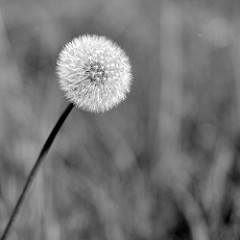

Image (CC BY 2.0)  by Stuart Heath

Image (CC BY 2.0)  by Micky**

Image (CC BY 2.0)  by { pranav }



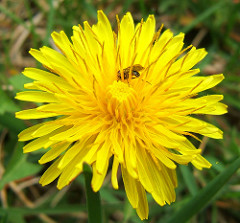

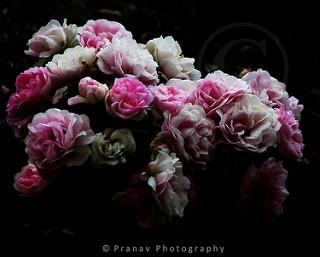

In [9]:
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path))
    print(caption_image(image_path))
    print()


In [7]:
# Determine the label for each image
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names



['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [8]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index



{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [9]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])



First 10 labels indices:  [2, 2, 2, 0, 4, 1, 0, 4, 2, 4]


In [10]:
# Load and format the images
img_path = all_image_paths[0]
img_path



'/home/yq0033/.keras/datasets/flower_photos/roses/15750320284_22ef21c682.jpg'

In [11]:
img_raw = tf.read_file(img_path)
print(repr(img_raw)[:100]+"...")



<tf.Tensor: id=2, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00\x...


In [12]:
# Decode it into an image tensor
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)
print(img_tensor.numpy().min())
print(img_tensor.numpy().max())



(333, 500, 3)
<dtype: 'uint8'>
0
255


In [13]:
# Resize it for your model
img_final = tf.image.resize_images(img_tensor, [192, 192])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())



(192, 192, 3)
0.0
1.0


In [14]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_images(image, [192, 192])
    image /= 255.0  # normalize to [0,1] range

    return image


def load_and_preprocess_image(path):
    image = tf.read_file(path)
    return preprocess_image(image)



In [15]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
plt.xlabel(caption_image(img_path))
plt.title(label_names[label].title())
print()



In [16]:
# Build a `tf.data.Dataset`
# A dataset of images
# The easiest way to build a `tf.data.Dataset` is using the
# `from_tensor_slices` method.
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

print(path_ds)
print('shape: ', repr(path_ds.output_shapes))
print('type: ', path_ds.output_types)
print()



<TensorSliceDataset shapes: (), types: tf.string>
shape:  TensorShape([])
type:  <dtype: 'string'>



In [17]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=4)



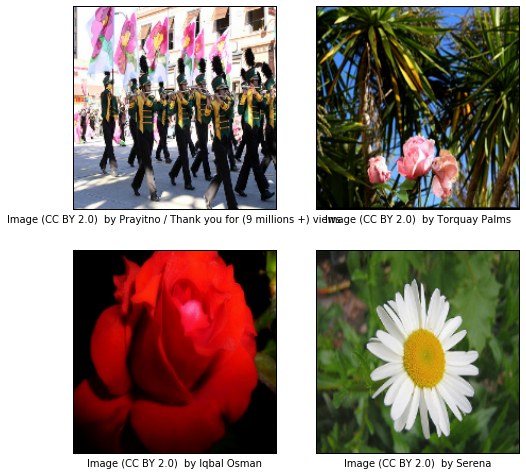

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for n, image in enumerate(image_ds.take(4)):
    plt.subplot(2,2,n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(caption_image(all_image_paths[n]))



In [19]:
# A dataset of `(image, label)` pairs
# Using the same `from_tensor_slices` method we can build a dataset of labels.
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

for label in label_ds.take(10):
    print(label_names[label.numpy()])
    


roses
roses
roses
daisy
tulips
dandelion
daisy
tulips
roses
tulips


In [20]:
# Since the datasets are in the same order we can just zip them together
# to get a dataset of `(image, label)` pairs.
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

print('image shape: ', image_label_ds.output_shapes[0])
print('label shape: ', image_label_ds.output_shapes[1])
print('types: ', image_label_ds.output_types)
print()
print(image_label_ds)



image shape:  (192, 192, 3)
label shape:  ()
types:  (tf.float32, tf.int64)

<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


In [21]:
# Basic methods for training.
# * To be well shuffled.
# * To be batches.
# * To repeat forever.
# * Batches to be available as soon as possible.
# These features can be easily added using the `tf.data` api.
BATCH_SIZE = 32

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
ds = ds.prefetch(buffer_size=128)
ds



<PrefetchDataset shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int64)>

In [22]:
# Pipe the dataset to a model.
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), 
                                               include_top=False)
mobile_net.trainable=False



9412608/9406464 [==============================] - 5s 1us/step


In [24]:
def change_range(image,label):
  return 2*image-1, label

keras_ds = ds.map(change_range)



In [25]:
image_batch, label_batch = next(iter(keras_ds))

feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)



(32, 6, 6, 1280)


In [26]:
# Build a model wrapped around MobileNet
model = tf.keras.Sequential([
    mobile_net,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(label_names))])



In [27]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)



min logit: -3.091044
max logit: 2.8986979

Shape: (32, 5)


In [28]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])



In [29]:
len(model.trainable_variables)



2

In [30]:
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [31]:
steps_per_epoch=tf.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch



115.0

In [32]:
model.fit(ds, epochs=1, steps_per_epoch=3)



Epoch 1/1
3/3 [==============================] - 3s 941ms/step - loss: 8.8890 - acc: 0.2188
